
<h1><center>  Etudes de la fréquence des sinistres corporels. </center></h1>

In [1]:
# Librairies :
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.preprocessing import StandardScaler


In [2]:
# Import des données :
df =  pd.read_csv("training_clean.csv")
df.head()

,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


# 2 - Retraitement des données : <a class="anchor" id="retraitements"></a>

In [ ]:
# Suppression des données erronées :
df= df.iloc[21:]

In [ ]:
df.columns

In [3]:
bins = [18, 25, 40, 60, 100]  # Adaptez ces valeurs selon vos observations spécifiques
labels = ['18-24', '25-39', '40-59', '60+']  # Les labels correspondent aux tranches d'âge

# Utilisez pd.cut pour binariser la colonne 'Age'
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Age_Bonus'] = df['Age'] * df['Bonus']

# Vérifiez le résultat
df[['Age', 'AgeGroup']].head()
# Groupez par 'AgeGroup' et puis appliquez 'value_counts' sur 'Numtpbi'
grouped_counts = df.groupby('AgeGroup')['Numtpbi'].value_counts().unstack(fill_value=0)

# Affichez le résultat
print(grouped_counts)

Numtpbi       0     1   2  3
AgeGroup                    
18-24     11931  1210  76  2
25-39     34548  1695  56  2
40-59     36734  1161  27  2
60+       12263   269   3  0


In [7]:
numeric_features = ['Age','Bonus', 'Poldur', 'Value', 'Adind', 'Group1','Density' ]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Gender', 'Occupation', 'Type', 'Category','SubGroup2', 'Group2' ]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
# Split the data into features and target variable
X = df[[ 'Gender', 'Type', 'Category', 'Occupation', 'Age',
       'Group1', 'Bonus', 'Poldur', 'Value', 'Adind', 'SubGroup2', 'Group2','Density'
       ]]
y = df['Numtpbi']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# 2- Modèles

## Regression

In [9]:
# Define the regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")




Mean Squared Error: 0.047020766030097916
R^2 Score: 0.008997252885893037


## Random Forest

In [10]:

# Define the regression model pipeline with a random forest regressor
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])


model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


/soft/conda/3/envs/dsa_dtg/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(0.05680136027205442, -0.19713711242800036)

In [11]:
param_grid_rf = {
    'regressor__n_estimators': [100, 200],  # Nombre d'arbres
    'regressor__max_depth': [10, 20],  # Profondeur maximale des arbres
    'regressor__min_samples_split': [2, 4],  # Nombre minimal d'échantillons requis pour diviser un nœud interne
    'regressor__min_samples_leaf': [1, 2]  # Nombre minimal d'échantillons requis pour être au niveau d'un nœud feuille
}

# Configuration et exécution de la recherche sur grille
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
# Affichage des meilleurs paramètres et du meilleur score R²
print("Meilleurs paramètres trouvés pour la forêt aléatoire:", grid_search_rf.best_params_)
print("Meilleur score R² pour la forêt aléatoire:", grid_search_rf.best_score_)

Meilleurs paramètres trouvés pour la forêt aléatoire: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Meilleur score R² pour la forêt aléatoire: 0.014814375217763954


In [23]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_rf

0.046929775322525354

## XGBOOST

In [12]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__max_depth': [3, 6, 9],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1, verbose=0)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

#print("Meilleurs paramètres trouvés :", grid_search_xgb.best_params_)
print("Meilleur score R² :", grid_search_xgb.best_score_)

/soft/conda/3/envs/dsa_dtg/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Meilleur score R² : 0.01972033575615108


In [22]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_xgb

0.04670914802733031

## Appréciation des resultats

In [15]:
dataProv = pd.DataFrame(X_test.index)
dataProv.columns = ['index']

dataProv['Obs'] = y_test.reset_index(drop=True)
#dataProv['Obs'] =np.array(y_test)
#dataProv['Pred_svm'] = y_pred_svm   
dataProv['Pred_rf'] = y_pred_rf
dataProv['Pred_xgb'] = y_pred_xgb
dataProv.head()

,index,Obs,Pred_rf,Pred_xgb
0,68281,0,0.132987,0.172178
1,40554,0,0.028414,0.033299
2,54244,0,0.035064,0.051982
3,70623,0,0.029609,0.045238
4,44352,0,0.046994,0.059110


In [16]:
dataFinale = df.copy().reset_index().merge(dataProv)
dataFinale.head()

,index,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,...,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,AgeGroup,Age_Bonus,Obs,Pred_rf,Pred_xgb
0,8,200115048,2009,Male,E,Medium,Unemployed,31,3,-40,...,355.0,1,0,0.000000,0.0,25-39,-1240,0,0.047696,0.041694
1,23,200114873,2009,Female,D,Medium,Housewife,62,13,-30,...,365.0,0,0,0.000000,0.0,60+,-1860,0,0.033108,0.031407
2,39,200114889,2009,Male,B,Large,Unemployed,41,10,-40,...,365.0,0,0,0.000000,0.0,40-59,-1640,0,0.033065,0.068544
3,53,200114903,2009,Male,B,Medium,Employed,25,9,-40,...,365.0,0,0,0.000000,0.0,25-39,-1000,0,0.046909,0.047161
4,70,200114920,2009,Male,A,Medium,Unemployed,43,16,85,...,365.0,3,0,1409.952732,0.0,40-59,3655,0,0.169114,0.149930


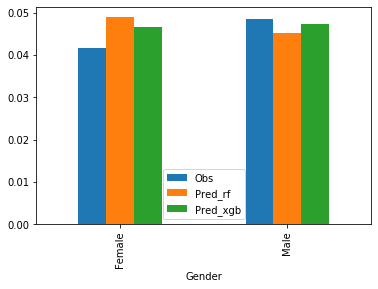

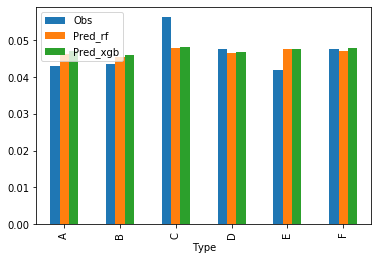

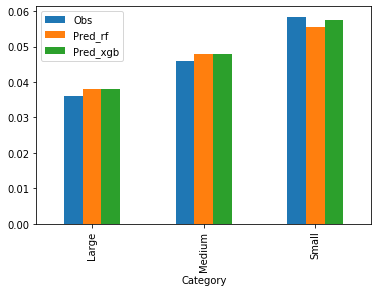

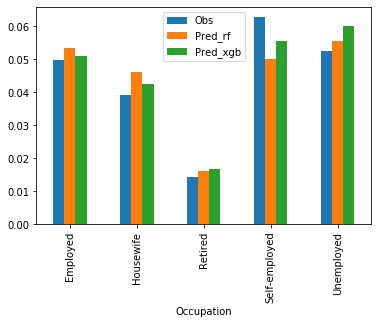

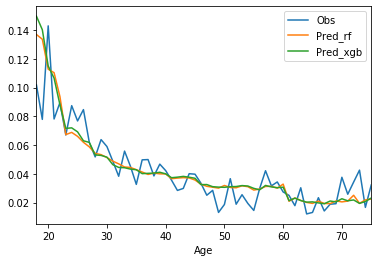

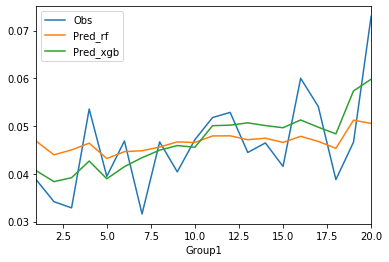

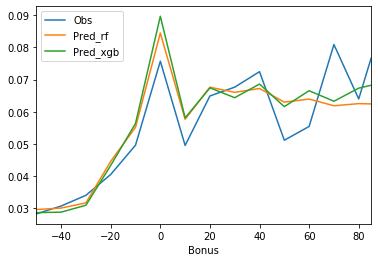

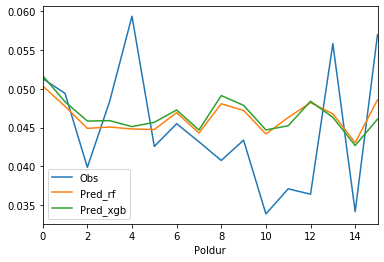

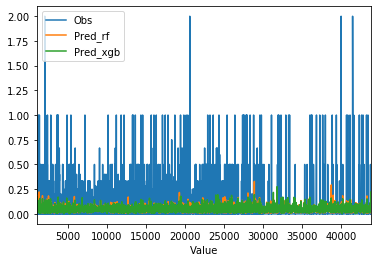

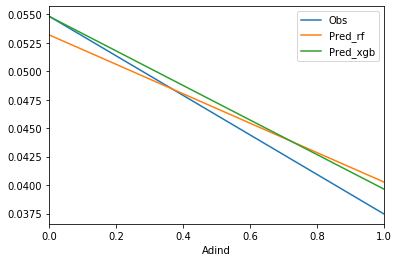

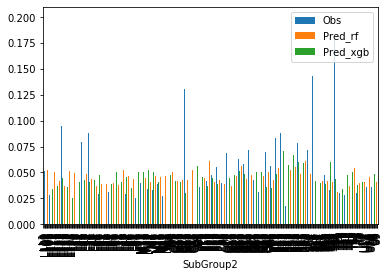

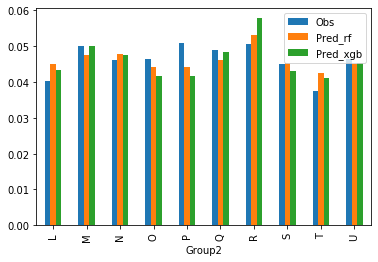

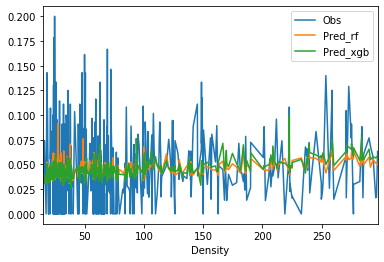

In [17]:
for var in dataFinale.columns[3:16]:
#     dataFinale.groupby([var])[['Obs', 'Pred_model', 'Pred_knn', 'Pred_tree', 'Pred_xgb']].mean().plot()
    dataPlot = dataFinale.groupby([var])[['Obs','Pred_rf', 'Pred_xgb']].mean()
        
    if dataFinale[var].dtypes == 'O':
        dataPlot.plot(kind='bar')
    else:
        dataPlot.plot()

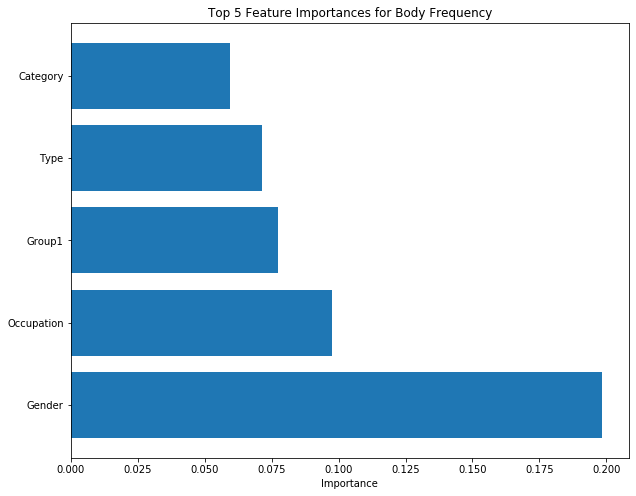

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Supposer que grid_search_rf est votre GridSearchCV avec un RandomForest comme estimateur dans une pipeline
best_rf_model = grid_search_rf.best_estimator_

# Accéder au RandomForestRegressor à l'intérieur de la pipeline
# L'étape du modèle est nommée 'regressor' ici, ajustez si nécessaire
random_forest_model = best_rf_model.named_steps['regressor']
feature_importances = random_forest_model.feature_importances_

# Assurez-vous que la liste des noms des caractéristiques correspond à ce que vous attendez
feature_names = ['Gender', 'Type', 'Category', 'Occupation', 'Age',
       'Group1', 'Bonus', 'Poldur', 'Value', 'Adind', 'SubGroup2', 'Group2','Density']  # Ajustez selon vos données

# Trier les caractéristiques par leur importance
sorted_idx = np.argsort(feature_importances)

# Sélectionner les 5 caractéristiques les plus importantes
top_5_idx = sorted_idx[-5:]

# Créer le graphique
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_5_idx)), feature_importances[top_5_idx], align='center')
plt.yticks(range(len(top_5_idx)), np.array(feature_names)[top_5_idx])
plt.xlabel('Importance')
plt.title("Top 5 Feature Importances for Body Frequency")
plt.gca().invert_yaxis()
plt.show()
 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


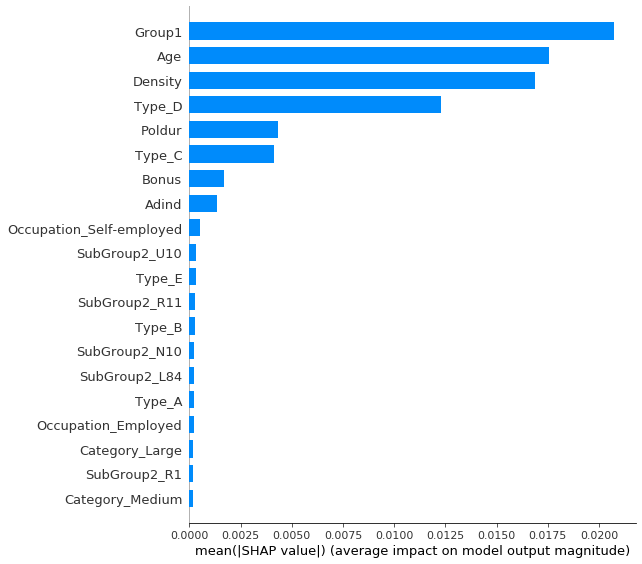

In [24]:
import shap
# One-hot encode categorical features
X_Ind_encoded = pd.get_dummies(X_test)
 
# Convert DataFrame to NumPy array
X_Ind_encoded_array = X_Ind_encoded.values
 
# Create a SHAP explainer
explainer = shap.TreeExplainer(random_forest_model )
 
# Calculate SHAP values
shap_values = explainer.shap_values(X_Ind_encoded_array)
 
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, plot_type="bar", feature_names=X_Ind_encoded.columns)


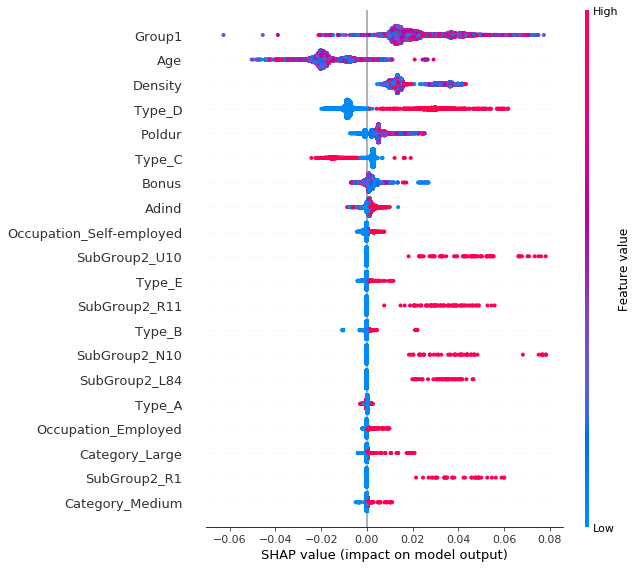

In [25]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, feature_names=X_Ind_encoded.columns)